### Simple Fitting Examples in RooFit

These examples show how to fit data using RooFit 

Create First an empty histogram with 50 bins with range [-10,10]

In [1]:
TH1D h1("h1","h1",50,-10,10);

Fill the histogram with 10000 Gaussian Random number with mean=1 and sigma=2

In [2]:
for (int i = 0; i < 1000; ++i) { h1.Fill(gRandom->Gaus(1,2));}

We could also use the function h1.FillRandom("gaus"), but we need to set the right parameters of the Gaussian function before.

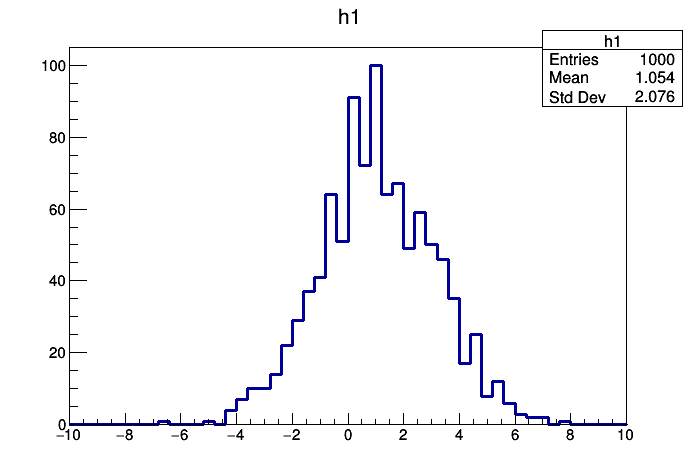

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [3]:
h1.Draw(); gPad->Draw();

Before Fitting we need to create the model using the RooFIt Workspace Factory.
Note we need to create an Extended Pdf if we want to fit also the normalization

In [4]:
RooWorkspace w("w");
RooAbsData * data = nullptr; 
RooAbsPdf * pdf = nullptr; 
RooRealVar * x = nullptr; 
RooPlot * plot = nullptr; 
RooFitResult * res = nullptr; 
RooPlot * plot2 = nullptr; 
RooHist * rhist = nullptr;


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [5]:
w.factory("Gaussian::gaus_pdf(x[-10,10],mean[-10,10],sigma[2,0,10])");
w.factory("ExtendPdf:model(gaus_pdf,n[100,0,10000])");  
pdf = w.pdf("model");
x = w.var("x");

Import the data (histogram) as a RooFit object
We could eventually use data generated directly from RooFit and do un binned or unbinned fit

In [6]:
w.var("x")->setBins(50);   // set the number of bins for x that will be used for the RooDataHist
data = new RooDataHist("binData","binData",*x,&h1);
// use data generated by RooFit
//data = w.pdf("gaus_pdf")->generate(*x,1000);   // generate 1000 data points
// generate directly in a binned data set
//data = w.pdf("gaus_pdf")->generateBinned(*x,1000); 

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(binData): fit range of variable x expanded to nearest bin boundaries: [-10,10] --> [-10,10]


We fit now the histogram using RooFit. If we fit the binned data set we will do an unbinned likelihood fit otherwise a 
binned likelihood fit.
We want to change also the default Minimization engine. We will use Minuit2
We want to save also the FitResult

In [7]:
res = pdf->fitTo(*data, RooFit::Minimizer("Minuit2"),RooFit::Save(true), RooFit::Minos(true));

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 1500 convergence for edm < 1 strategy 1
MnSeedGenerator: for initial parameters FCN = -2216.005045527
MnSeedGenerator: Initial state:   - FCN =  -2216.005045527 Edm =      890.712 NCalls =     13
VariableMetric: start iterating until Edm is < 0.001
VariableMetric: Initial state   - FCN =  -2216.005045527 Edm =      890.712 NCalls =     13
VariableMetric: Iteration #   0 - FCN =  -2216.005045527 Edm =      890.712 NCalls =     13
VariableMetric: Iteration #   1 - FCN =  -3572.267078507 Edm =      64.6826 NCalls =     27
VariableMetric: Iteration #   2 - FCN =  -3738.341510674 Edm =      10.3122 NCalls =     36
VariableMetric: Iteration #   3 - FCN =  -3758.936303919 Edm =   0.00879882 NCalls =     45
VariableMetric: Iteration #   4 - FCN =  -3758.948316556 Edm

Info in <Minuit2>: Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate
Info in <Minuit2>: VariableMetricBuilder: no improvement in line search
Info in <Minuit2>: VariableMetricBuilder: no improvement in line search


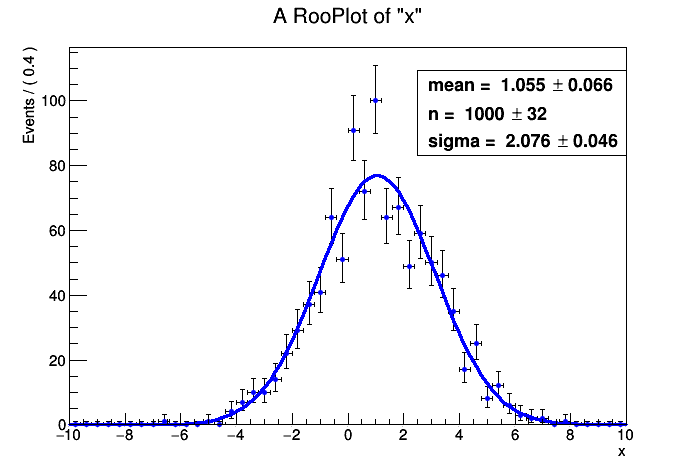

In [8]:
// create a RooPlot object and plot the data and then the fitted function
plot = x->frame(); 
data->plotOn(plot); 
pdf->plotOn(plot);
// plot also the fit parameters
pdf->paramOn(plot, RooFit::Layout(0.6,0.9,0.85));
plot->Draw(); 
gPad->Draw(); 

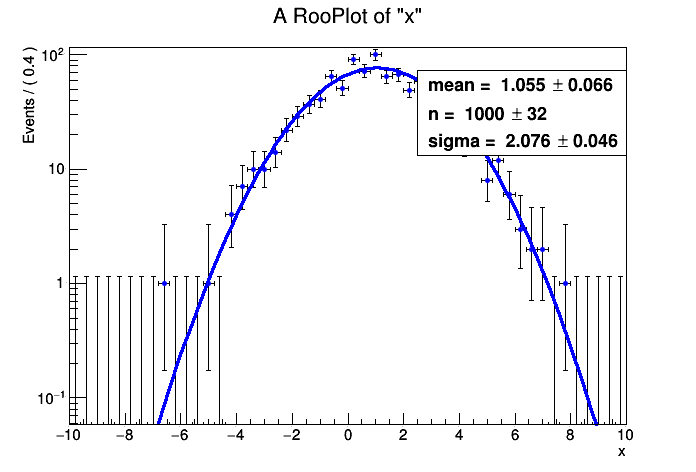

In [9]:
gPad->SetLogy(true); // to set log scale in y
gPad->Draw();

We can now print the result of the Fit

In [10]:
res->Print();


  RooFitResult: minimized FCN value: -3758.95, estimated distance to minimum: 7.85519e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 MINOS=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                  mean    1.0548e+00 +/-  6.56e-02
                     n    9.9992e+02 +/-  3.16e+01
                 sigma    2.0755e+00 +/-  4.65e-02



We now get the corre;ation matrix of the fit from the TFitResult class

In [11]:
auto corrMatrix = res->correlationMatrix(); 

In [12]:
corrMatrix.Print(); 


3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |          1  -6.341e-09   0.0009332 
   1 | -6.341e-09           1  -6.338e-09 
   2 |  0.0009332  -6.338e-09           1 



In [13]:
auto sigma = (RooRealVar*) res->floatParsFinal().find("sigma");
std::cout  << "Gaussian sigma = " << sigma->getVal() << "  +/- " << sigma->getError() << std::endl;

Gaussian sigma = 2.0755  +/- 0.0464605


If we want to access the MINOS asymmetric error, we can get still them from the RooRealVar object

In [14]:
std::cout  << "Gaussian sigma = " << sigma->getVal() << "  + " << sigma->getAsymErrorHi() << " - " << sigma->getAsymErrorLo() << std::endl;

Gaussian sigma = 2.0755  + 0.0468086 - -0.0460974


RooFit can also plot the residuals from the function and the data 

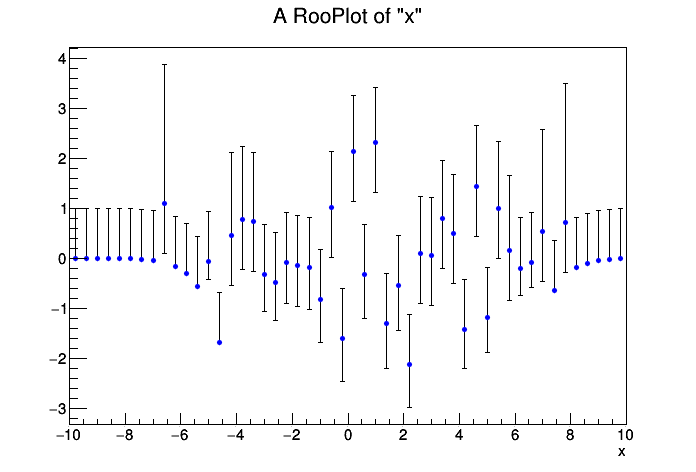

In [15]:
rhist = plot->pullHist();
//auto pullHist  = plot->pullHist();
// Create a new frame to draw the residual distribution and add the distribution to the frame
plot2 = x->frame() ;
plot2->addPlotable(rhist,"P") ;
plot2->Draw();
gPad->SetLogy(false);
gPad->Draw();

In [16]:
// we compute now also the normalized chi-squared
std::cout << "Chi-square from RooFit = " << plot->chiSquare() << std::endl;

Chi-square from RooFit = 0.99601


#### Part 2:  Fit Bias Study

We study now the Fit Bias for the sigma parameter. We look at the difference obtained by using 3 different fit methods: 

1. Chisquare fit using the observed error (default case in ROOT) 
2. Chisquare fit using the expected error (option "P" - Pearson chi2)
3. Binned maximum likelihood fit (option "L")

In [17]:
TH1 * hs = nullptr;

In [18]:
hs = new TH1D("hs","Sigma pull distribution",50,-4,4);

In [19]:
hs->Reset(); // in case we run a second time
for (int iexp = 0; iexp < 1000; ++iexp) { 
    w.var("mean")->setVal(0);
    w.var("sigma")->setVal(2);
    //RooDataSet * data = pdf->generate(*x,1000);
    RooDataHist * data = pdf->generateBinned(*x,1000);
    pdf->fitTo(*data,RooFit::PrintLevel(-1),RooFit::Extended(true));
    //w.pdf("gaus_pdf")->chi2FitTo(*data,RooFit::PrintLevel(-1));  // need to use non-extended pdf in GausFit
    hs->Fill( (w.var("sigma")->getVal()- 2)/w.var("sigma")->getError() );  // to get sigma and its error
    delete data;
}
std::cout << "generated 1000 experiments - <Sigma> = " << hs->GetMean() << " +/- " << hs->GetMeanError() << std::endl; 

generated 1000 experiments - <Sigma> = -0.0747356 +/- 0.030804


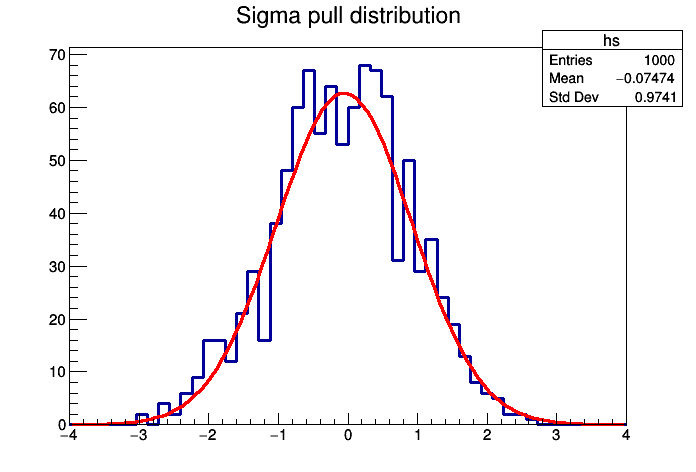

 FCN=49.0154 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=1.10214e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.27274e+01   2.58583e+00   7.02614e-03  -6.51842e-04
   2  Mean        -5.20430e-02   3.25289e-02   1.11089e-04   1.86570e-02
   3  Sigma        9.71969e-01   2.57302e-02   2.38005e-05  -1.40775e-01


In [20]:
hs->Fit("gaus"); 
gPad->Draw();